In [ ]:
import os
import cv2
import numpy as np
import torch
import dlib
from imutils import face_utils
from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils.download_util import load_file_from_url
from torchvision import transforms  
import torch.nn as nn
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn.functional as F
import math
import time
from imutils import face_utils
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import mediapipe
# from BaseModels.resnetModels import BB_model
from BaseModels.efficientnetModels import BB_model
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from scipy.spatial import distance
import sys
sys.path.append("../../")
from utils import *
from BaseModels.unet_model import  UNET

    


In [2]:

# # Load Model 256
model_U = torch.load(
    "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Experiments/U2net/U2NET_MULTICLASS_IMG_256_DIC_batch_8/Miche_model_2023_04_11_22:14:26_val_iou0.900.pt", map_location=device)


model_U.eval()

RESIZE_AMT = 256

In [3]:
# Get the validation Data 


#Gi4e
val_csv_path = "/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/GI4E/AllCoords/gi4eAllCoordinatesTest.csv"

val_df = pd.read_csv(val_csv_path)



In [5]:
detector = None
predictor = None
GAN_MODEL = None
IRIS_MODEL = None
EYE_AR_THRESH = 0.2

mp_face_mesh = mediapipe.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
# GI4E
padded_amt = 15



In [15]:
#GI4E
IMG_DIR = "/home/nipun/Documents/Uni_Malta/Datasets/gi4e_database/images/"



In [ ]:
# GI4E
count = 0

maximizedNormalizedError = []
for _, row in val_df.iterrows():

    img_name = row["ImageName"]

    coords = [float(j) for j in row["Coordinates"][1:-1].split(",")]

    left_outer = coords[0:2]
    left_center = coords[2:4]
    left_inner = coords[4:6]

    right_inner = coords[6:8]
    right_center = coords[8:10]
    right_outer = coords[10:12]

    # print(left_center)
    # print(right_center)

    IPD = distance.euclidean(left_center, right_center)

    # print(IPD)

    image_filepath = os.path.join(IMG_DIR, img_name)

    # print(image_filepath)

    # print(coords)

    count += 1
    img = cv2.imread(image_filepath)

    results = face_mesh.process(img)

    if results.multi_face_landmarks is not None:
        landmarks = results.multi_face_landmarks[0]

        shape_arr = mpArrayToNumpy(landmarks, img)

        left_eye, right_eye, Leye, Reye = cropped_image(img, shape_arr,padded_amt)

        pred_l_eye, pred_r_eye = predict_image_masku2net(
            model_U, left_eye,RESIZE_AMT), predict_image_masku2net(model_U, right_eye,RESIZE_AMT)
        
        
        left_centroid = imageCenterFromConnectedComponent(pred_l_eye)[-1]
        right_centroid = imageCenterFromConnectedComponent(pred_r_eye)[-1]
        
        
        
        
        

        pred_l_eye_center = rescale_coordinate(left_centroid, left_eye, RESIZE_AMT)

        pred_r_eye_center = rescale_coordinate(right_centroid, right_eye, RESIZE_AMT)

        
        
        
        
        
        
        
        
        # cv2.circle(left_eye, (int(pred_l_eye_center[0]), int(
        #     pred_l_eye_center[1])), 1, (0, 255, 0), -1)

        # cv2.circle(right_eye, (int(pred_r_eye_center[0]), int(
        #     pred_r_eye_center[1])), 1, (0, 255, 0), -1)
        

        # fig, axes = plt.subplots(2, 2)

        # fig.set_figheight(8)
        # fig.set_figwidth(8)

        # axes[0][0].imshow(left_eye)
        # axes[0][1].imshow(pred_l_eye)

        # axes[1][0].imshow(right_eye)
        # axes[1][1].imshow(pred_r_eye)

        # count += 1
        

        
        pred_l_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
            pred_l_eye_center, Leye)
        pred_r_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
            pred_r_eye_center, Reye)
        
        

        # # print(pred_l_eye_toOriginaImage)
        # # print(coords[2:4])

        cv2.circle(img, (int(pred_l_eye_toOriginaImage[0]), int(
            pred_l_eye_toOriginaImage[1])), 1, (0, 255, 0), -1)

        cv2.circle(img, (int(pred_r_eye_toOriginaImage[0]), int(
            pred_r_eye_toOriginaImage[1])), 1, (0, 255, 0), -1)
        
        
        
        cv2.circle(img, (int(left_center[0]), int(
            left_center[1])), 1, (0, 0, 255), -1)

        cv2.circle(img, (int(right_center[0]), int(
            right_center[1])), 1, (0, 0, 255), -1)
        
        
        # plt.figure(figsize=(10,10))
        # plt.imshow(img[:,:,::-1])
        # plt.show()

        left_eye_euclidea_distance = distance.euclidean(
            pred_l_eye_toOriginaImage, left_center)

        right_eye_euclidea_distance = distance.euclidean(
            pred_r_eye_toOriginaImage, right_center)

        eMax = max(left_eye_euclidea_distance, right_eye_euclidea_distance)/IPD

        print(eMax)

        maximizedNormalizedError.append(eMax)
        
        # if count == 50:
        #     break
    else:

        print(
            f"MediaPipe was failed to detect the faces on the image name {obj[0]}")
        continue

    # if count ==1:
    #     break




/home/nipun/.local/lib/python3.10/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


0.012508279457216063
0.01957227227551838
0.022175116485342015


0.021107641379210645
0.03003302799254976
0.0149493010066666
0.018974567687679432
0.016117119205155853
0.023088825898461656
0.01697373880538454
0.018074897334571106
0.015941356636039905
0.01946256621539698
0.021083695056653303
0.02155866863914751
0.01446446417349577
0.019508521519668486
0.021023148428904372
0.02148613614247528
0.021867423099835432
0.028861273152734603
0.0255071551299227
0.03534235280681178
0.026493933908454125
0.021526669191678626
0.025393647791277094
0.02060478537386328
0.019202577233894513
0.011577683485574827
0.022586071010689397
0.01957446862809003
0.022298070220028717
0.024964651585263377
0.02916090894802082
0.016108922703233868
0.03941136153280807
0.012446513523177419
0.02032955507185794
0.012221104757654082
0.017282556148523094
0.019339393090048652
0.012371026501234837
0.009819889945161368
0.025066665466635114
0.028379335794238784
0.04259841110329761
0.01973977114237263
0.02796751437604612
0.02631429594097584
0.026738164290595997
0.01647280902935872
0.01927917252

In [20]:
e_0_25 = CheckForLess(maximizedNormalizedError,0.25)

e_0_05 = CheckForLess(maximizedNormalizedError,0.05)

e_0_1 = CheckForLess(maximizedNormalizedError,0.1)


e_0_025 = CheckForLess(maximizedNormalizedError, 0.025)

In [21]:
(len(e_0_25)/len(maximizedNormalizedError)) *100

97.36842105263158

In [22]:
(len(e_0_05)/len(maximizedNormalizedError)) * 100

96.9298245614035

In [23]:
len(e_0_1)/len((maximizedNormalizedError)) * 100

97.36842105263158

In [24]:
len(e_0_025)/len((maximizedNormalizedError)) * 100

67.98245614035088

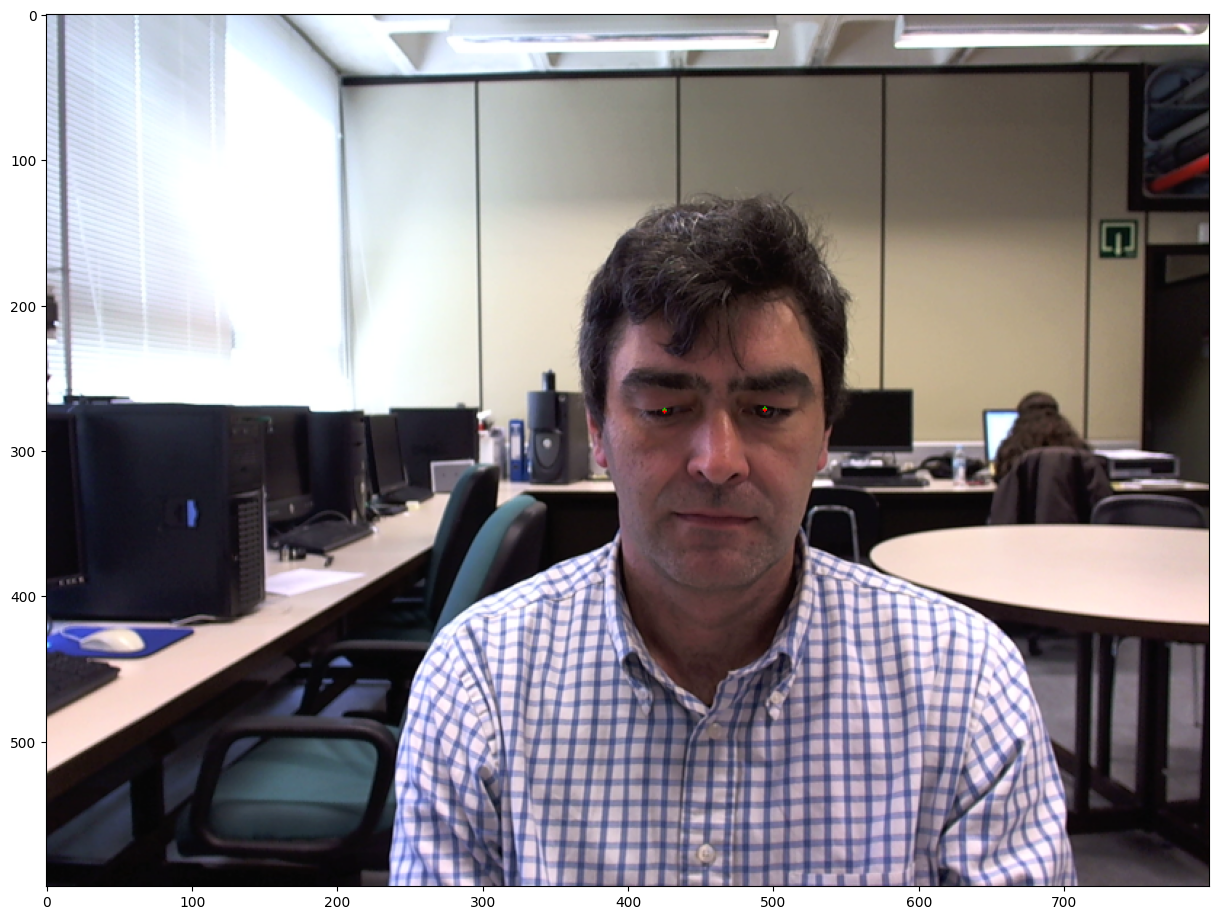

: 

In [25]:
plt.figure(figsize=(15,15))
plt.imshow(img[:,:,::-1])
